# Implicit Functions

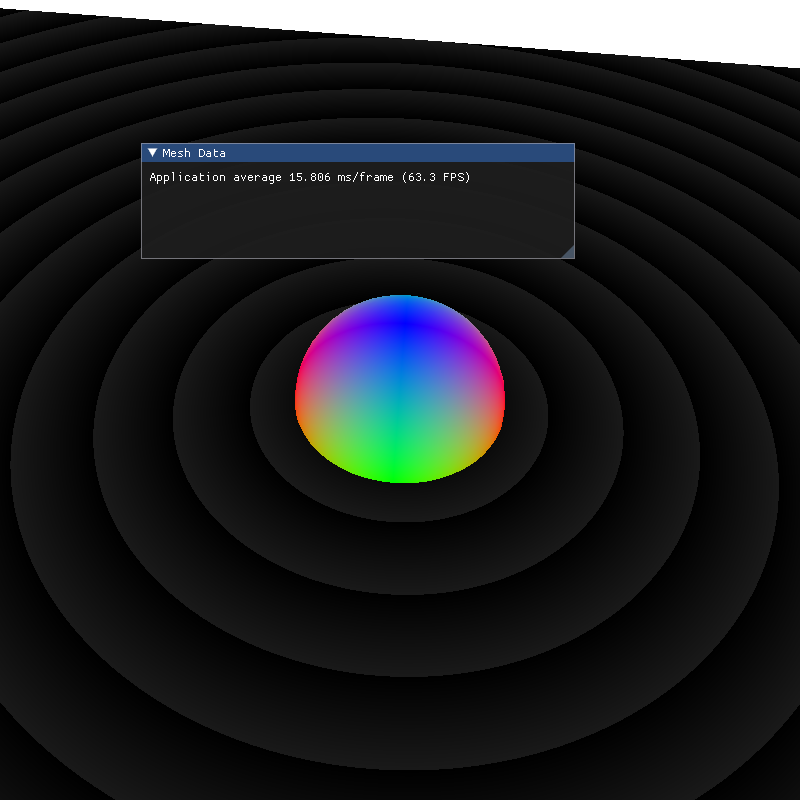

In [7]:
import os
import sys
import pathlib

parentdir = os.path.dirname(pathlib.Path().resolve())

sys.path.insert(0, parentdir) 

import run_example

name = run_example.ScreenShotExample(os.path.abspath(pathlib.Path().resolve()), capture_frame=40)

from IPython.display import Image

Image(filename=f'Documentation/{name}.png')

There are two things to notice on this file, first, this is the first example that uses imgui to display system information. Neverengine provides its own imgui backend which is fully integrated, so you just need to initialize it through  `InitImgui()`. Then you can call Imgui functions like in any sample from the Imgui website, and when you are ready to render your imgui elements, merely call `RenderImgui()` during your frame.

More excitingly, this demo displays the engine's dual contouring implementation. Dual contouring is a way to create explicit meshes for implicit surfaces.

An implicit surface is a surface that can be respresented with a signed distance function $f(x,y,z) = d$, such that $d < 0$ when we are inside of the surface, $d > 0$ when we are outside and $d == 0$ when we are exactly at the surface.

The easiest example is a sphere, if $P$ is a point and $C$ is the center of the sphere, then when $\|P-C\| < R$ ($R$ the radius) the point is inside the sphere.

The idea is to embed our surface into a cartesian grid, for example if we wanted to process a sphere it coudl look like the following:

In [8]:
import pathlib
import os, sys
from IPython.display import SVG, display, HTML

parent = os.path.dirname(pathlib.Path().resolve())

sys.path.append(parent)
from diagram_utils import *

c.items.clear()
c.layers.clear()

def DrawMockSphere(layer):
    if layer == 1:
        DrawCircle((1.8, 1.2), 1.5, tcolor=light_blue + (0.5,))

points = np.array([(0, 0), (0, 1), (1, 0), (1, 1)])

Draw3DGrid(
    (3, 3, 3),
    highlight=False,
    highlight_coords=(1, 1, 1),
    draw_at_layer=DrawMockSphere
)

pathlib.Path("Documentation").mkdir(parents=True, exist_ok=True)
image_path = os.path.join("Documentation", "SphereGrid")
c.writeSVGfile(image_path)

svg_file = image_path + '.svg'
import svgutils
svg = svgutils.transform.fromfile(svg_file)
original = svgutils.compose.SVG(svg_file)
scale = 4.0
original.scale(scale)

import re
width = re.findall("\d+\.\d+", svg.width)[0]
height = re.findall("\d+\.\d+", svg.height)[0]

figure = svgutils.compose.Figure(float(height) * 1.15 * scale, float(width) * 1.15 * scale, original)
figure.moveto(20 * scale, 100 * scale)
figure.save(image_path + ".svg")

svg_file = image_path + '.svg'
display(HTML(f"<img src='{svg_file}'>"))



The grid has 2 primary parameters, a scale $s$ which is the side length of the box/grid, which needs to be large enough to contain the portion of the SDF we want to mesh, but no larger as it would waste space. The second parameter is the resolution $n$ which is the number of cells across one dimension of the grid. More cells means better resolution, but it also means longer processing times and memory use.

In [9]:
import pathlib
import os, sys
from IPython.display import SVG, display, HTML
from IPython.display import clear_output

parent = os.path.dirname(pathlib.Path().resolve())

sys.path.append(parent)
from diagram_utils import *

c.items.clear()
c.layers.clear()

points = np.array([(0, 0), (0, 1), (1, 0), (1, 1)])

Draw3DGrid((3, 3, 3), highlight=False, highlight_coords=(1, 1, 1))

DrawDoubleArrow((-0.7, 0.3), (0.3, -0.7), tcolor=light_blue)

offset = 0.9
interim = 0.13333
DrawLine((0.7, -0.8), (0.7 + offset, -0.8), stroke=SOLID_LINE, tcolor=light_green)
DrawLine(
    (0.7 + offset + interim, -0.8),
    (0.7 + interim + offset * 2, -0.8),
    stroke=SOLID_LINE,
    tcolor=light_green,
)
DrawLine(
    (0.7 + (offset + interim) * 2, -0.8),
    (0.7 + (offset + interim) * 2 + offset, -0.8),
    stroke=SOLID_LINE,
    tcolor=light_green,
)

DrawText((-0.3, -0.4), r"$s$", tcolor=light_blue)

DrawText((2.2, -1.1), r"$n$", tcolor=light_green)

image_path = os.path.join("Documentation", "DCGrid")
c.writeSVGfile(image_path)

svg_file = image_path + '.svg'
import svgutils
svg = svgutils.transform.fromfile(svg_file)
original = svgutils.compose.SVG(svg_file)
scale = 4.0
original.scale(scale)

import re
width = re.findall("\d+\.\d+", svg.width)[0]
height = re.findall("\d+\.\d+", svg.height)[0]

figure = svgutils.compose.Figure(float(height) * 1.15 * scale, float(width) * 1.15 * scale, original)
figure.moveto(20 * scale, 100 * scale)
figure.save(image_path + ".svg")
clear_output()

svg_file = image_path + '.svg'
display(HTML(f"<img src='{svg_file}'>"))


What we will do with this grid is to process our SDF in two passes to create a mesh. First we need to identify which cells should have vertices, will iterate over every cell in the grid:

In [10]:
import pathlib
import re
import math
import os, sys
from IPython.display import SVG, display
from IPython.display import clear_output
import svgutils
from IPython.display import HTML, display

parent = os.path.dirname(pathlib.Path().resolve())

sys.path.append(parent)
from diagram_utils import *

for i in range (27):
    c.items.clear()
    c.layers.clear()

    points = np.array([(0, 0), (0, 1), (1, 0), (1, 1)])
    
    z = math.floor(i / 9)
    y = math.floor((i % 9) / 3)
    x = i % 3
    
    Draw3DGrid((3, 3, 3), highlight=True, highlight_coords=(x, y, z))

    image_path = os.path.join("Documentation", f"Grid_{i}")
    c.writeSVGfile(image_path)

    svg_file = image_path + '.svg'

    svg = svgutils.transform.fromfile(svg_file)
    original = svgutils.compose.SVG(svg_file)
    scale = 1.4
    original.scale(scale)
    
    width = re.findall("\d+\.\d+", svg.width)[0]
    height = re.findall("\d+\.\d+", svg.height)[0]

    figure = svgutils.compose.Figure(float(height) * 1.15 * scale, float(width) * 1.15 * scale, original)
    figure.moveto(20 * scale, 100 * scale)
    figure.save(image_path + ".svg")
    clear_output()

    svg_path = image_path + ".svg"

html = ""
for i in range(3):
    row = ""
    for j in range(3):
        index = ((2-i) * 3 + j + 18)
        svg_path = os.path.join("Documentation", f"Grid_{index}.svg")
        row += f"<td><img src='{svg_path}'></td>"
    html += f"<tr>{row}</tr>"

html = f"<table>{html}</table>"    
display(HTML(html))

And so on ...

At each cell we will test each of the 12 edges to see if there is a sign change, and if there is a sign change we create a vertex somewhere in the current cell. So for example assume we are on some cell on the interior of the volume:

In [11]:
import pathlib
import os, sys
import svgutils
import re
from IPython.display import SVG, display
from IPython.display import clear_output

parent = os.path.dirname(pathlib.Path().resolve())

sys.path.append(parent)
from diagram_utils import *

c.items.clear()
c.layers.clear()

Draw3DGrid((3, 3, 3), highlight=True, highlight_coords=(1, 1, 1))

image_path = os.path.join("Documentation", f"single_grid")
c.writeSVGfile(image_path)

svg_file = image_path + '.svg'

svg = svgutils.transform.fromfile(svg_file)
original = svgutils.compose.SVG(svg_file)
scale = 4
original.scale(scale)

width = re.findall("\d+\.\d+", svg.width)[0]
height = re.findall("\d+\.\d+", svg.height)[0]

figure = svgutils.compose.Figure(float(height) * 1.15 * scale, float(width) * 1.15 * scale, original)
figure.moveto(20 * scale, 100 * scale)
figure.save(image_path + ".svg")
clear_output()

svg_file = image_path + '.svg'
display(HTML(f"<img src='{svg_file}'>"))

We can separate the 12 edges into 3 groups, (coloured blue, green and red), based on which axis they are aligned with (assumming an axis aligned grid):

In [12]:
import pathlib
import os, sys
import re
import svgutils
from IPython.display import SVG, display
from IPython.display import clear_output

parent = os.path.dirname(pathlib.Path().resolve())

sys.path.append(parent)
from diagram_utils import *

c.items.clear()
c.layers.clear()

def DrawEdgeBox(points, styles=[SOLID_LINE] * 12, tcolor=(0, 0, 0)):
    width = 0.02

    offset = np.array([-0.3, 0.3])
    bpoints = points + offset
    DrawLine(bpoints[0], bpoints[2], width=width, stroke=styles[5], tcolor=light_blue)
    DrawLine(bpoints[0], bpoints[1], width=width, stroke=styles[4], tcolor=light_red)
    DrawLine(bpoints[1], bpoints[3], width=width, stroke=styles[6], tcolor=light_blue)
    DrawLine(bpoints[2], bpoints[3], width=width, stroke=styles[7], tcolor=light_red)

    DrawLine(points[0], bpoints[0], width=width, stroke=styles[8], tcolor=light_green)
    DrawLine(points[1], bpoints[1], width=width, stroke=styles[9], tcolor=light_green)
    DrawLine(points[2], bpoints[2], width=width, stroke=styles[10], tcolor=light_green)
    DrawLine(points[3], bpoints[3], width=width, stroke=styles[11], tcolor=light_green)

    DrawLine(points[0], points[1], width=width, stroke=styles[0], tcolor=light_red)
    DrawLine(points[2], points[3], width=width, stroke=styles[3], tcolor=light_red)
    DrawLine(points[0], points[2], width=width, stroke=styles[1], tcolor=light_blue)
    DrawLine(points[1], points[3], width=width, stroke=styles[2], tcolor=light_blue)

points = np.array([(0, 0), (0, 1), (1, 0), (1, 1)])
DrawEdgeBox(points)

image_path = os.path.join("Documentation", f"BoxEdges")
c.writeSVGfile(image_path)
    
svg_file = image_path + '.svg'

svg = svgutils.transform.fromfile(svg_file)
original = svgutils.compose.SVG(svg_file)
scale = 12
original.scale(scale)

width = re.findall("\d+\.\d+", svg.width)[0]
height = re.findall("\d+\.\d+", svg.height)[0]

figure = svgutils.compose.Figure(float(height) * 1.15 * scale, float(width) * 1.15 * scale, original)
figure.moveto(12 * scale, 40 * scale)
figure.save(image_path + ".svg")
clear_output()

svg_path = image_path + ".svg"
display(HTML(f"<table><tr><td><img src='{svg_path}'></td></tr></table>"))


For each edge, we check the 2 end points and see if they have the same sign, if they don't, it is guaranteed that the boundary of the surface intersects the edge. This also means it passes through the interiors cells that shere that edge. In other words, if at least one edge has 2 different signs at its endpoints, we will generate a vertex inside the current cell. There are many ways to do this, the simplest is to pick the center of the cell, although that creates a rather blocky result. Another simple method is to use gradient descent to optimize the vertex location, a good choice of Loss function is needed. A decent formulation for the loss is:

$$L(X) = \lambda f(X)^2 + \|X - c\|^2$$

With $X$ any point in $\mathbb{R}^n$, $c$ the center of the cell, $f$ the sdf function and $\lambda$ a user defined coefficient that should be relatively large.

Once all cells have been visited and we have generated all the vertices, we need to create the connectivity information. Now, instead of visiting cells, we iterate over every edge (or rather over the edge triplet defined by the first 3 axis aligned edges of each cell) and once again test if there is a sign change. If the signs of the endpoints are different, then we know that the 4 cells that surround this edge have vertices inside of them. So for example, assume we have 2 slices of the grid at 2 layers like this, where red is negative and blue is positive:

In [13]:
import pathlib
import os, sys
import re
import svgutils
from IPython.display import SVG, display, HTML
from IPython.display import clear_output

parent = os.path.dirname(pathlib.Path().resolve())

sys.path.append(parent)
from diagram_utils import *

c.items.clear()
c.layers.clear()

scale = 5
for i in range(2):
    for j in range(2):
        DrawLine(np.array((i, j)) * scale, np.array((i + 1, j)) * scale, stroke=SOLID_LINE, width=0.02 * scale)
        DrawLine(np.array((i, j)) * scale, np.array((i, j + 1)) * scale, stroke=SOLID_LINE, width=0.02 * scale)
        DrawLine(np.array((i + 1, j)) * scale, np.array((i + 1, j + 1)) * scale, stroke=SOLID_LINE, width=0.02 * scale)
        DrawLine(np.array((i, j + 1)) * scale, np.array((i + 1, j + 1)) * scale, stroke=SOLID_LINE, width=0.02 * scale)

DrawPoint((0 * scale, 0 * scale), 0.05 * scale, tcolor=light_blue)
DrawPoint((0 * scale, 1 * scale), 0.05 * scale, tcolor=light_blue)
DrawPoint((0 * scale, 2 * scale), 0.05 * scale, tcolor=light_blue)
DrawPoint((1 * scale, 0 * scale), 0.05 * scale, tcolor=light_blue)
DrawPoint((1 * scale, 1 * scale), 0.05 * scale, tcolor=light_blue)
DrawPoint((1 * scale, 2 * scale), 0.05 * scale, tcolor=light_red)
DrawPoint((2 * scale, 0 * scale), 0.05 * scale, tcolor=light_blue)
DrawPoint((2 * scale, 1 * scale), 0.05 * scale, tcolor=light_red)
DrawPoint((2 * scale, 2 * scale), 0.05 * scale, tcolor=light_red)

points = [
    (0.1 * scale , 2.2 * scale), 
    (0.3 * scale, 1.7 * scale), 
    (1.5 * scale, 1.5 * scale), 
    (1.7 * scale, 0.7 * scale), 
    (2.5 * scale, 0.7 * scale)]
DrawCurve(points, width=0.04 * scale)

pathlib.Path("Documentation").mkdir(parents=True, exist_ok=True)
image_path = os.path.join("Documentation", f"slice_view_0")
c.writeSVGfile(image_path)

c.items.clear()
c.layers.clear()

scale = 5
for i in range(2):
    for j in range(2):
        DrawLine(np.array((i, j)) * scale, np.array((i + 1, j)) * scale, stroke=SOLID_LINE, width=0.02 * scale)
        DrawLine(np.array((i, j)) * scale, np.array((i, j + 1)) * scale, stroke=SOLID_LINE, width=0.02 * scale)
        DrawLine(np.array((i + 1, j)) * scale, np.array((i + 1, j + 1)) * scale, stroke=SOLID_LINE, width=0.02 * scale)
        DrawLine(np.array((i, j + 1)) * scale, np.array((i + 1, j + 1)) * scale, stroke=SOLID_LINE, width=0.02 * scale)

DrawPoint((0 * scale, 0 * scale), 0.05 * scale, tcolor=light_blue)
DrawPoint((0 * scale, 1 * scale), 0.05 * scale, tcolor=light_blue)
DrawPoint((0 * scale, 2 * scale), 0.05 * scale, tcolor=light_blue)
DrawPoint((1 * scale, 0 * scale), 0.05 * scale, tcolor=light_blue)
DrawPoint((1 * scale, 1 * scale), 0.05 * scale, tcolor=light_red)
DrawPoint((1 * scale, 2 * scale), 0.05 * scale, tcolor=light_red)
DrawPoint((2 * scale, 0 * scale), 0.05 * scale, tcolor=light_blue)
DrawPoint((2 * scale, 1 * scale), 0.05 * scale, tcolor=light_red)
DrawPoint((2 * scale, 2 * scale), 0.05 * scale, tcolor=light_red)

points = [
    (0.1 * scale , 2.2 * scale), 
    (0.3 * scale, 1.7 * scale), 
    (0.5 * scale, 0.5 * scale), 
    (1.7 * scale, 0.7 * scale), 
    (2.5 * scale, 0.7 * scale)]
DrawCurve(points, width=0.04 * scale)
    
pathlib.Path("Documentation").mkdir(parents=True, exist_ok=True)
image_path = os.path.join("Documentation", f"slice_view_1")
c.writeSVGfile(image_path)

display(HTML(f"<table><tr><td><img src='Documentation/slice_view_0.svg'></td><td><img src='Documentation/slice_view_1.svg'></td></tr></table>"))


Where the first image is the layer immediately below the second, then that center edge has 2 different signs at its endpoints and thus the 4 surrounding cells must have vertices associated with them. Thus we establish the connectivity by triangulationg the "quad" described by the cell centers:

In [14]:
import pathlib
import os, sys
import re
import svgutils
from IPython.display import SVG, display, HTML
from IPython.display import clear_output

parent = os.path.dirname(pathlib.Path().resolve())

sys.path.append(parent)
from diagram_utils import *

scale = 8
c.items.clear()
c.layers.clear()

offset = np.array([0.5, 0.5]) * scale

points = [
    np.array((0, 0)) * scale, 
    np.array((0, 1)) * scale, 
    np.array((1, 0)) * scale, 
    np.array((1, 1)) * scale]

DrawTriangle(
    points[0] + offset,
    points[1] + offset,
    points[3] + offset,
    outline_color=light_blue,
    fill_color=lighter_blue,
    width = 0.02 * scale
)
DrawTriangle(
    points[0] + offset,
    points[2] + offset,
    points[3] + offset,
    outline_color=light_blue,
    fill_color=lighter_blue,
    width = 0.02 * scale
)

for i in range(2):
    for j in range(2):
        DrawLine( np.array((i, j)) * scale, np.array((i + 1, j)) * scale, stroke=SOLID_LINE, width=0.02 * scale)
        DrawLine( np.array((i, j)) * scale, np.array((i, j + 1)) * scale, stroke=SOLID_LINE, width=0.02 * scale)
        DrawLine( np.array((i + 1, j)) * scale, np.array((i + 1, j + 1)) * scale, stroke=SOLID_LINE, width=0.02 * scale)
        DrawLine( np.array((i, j + 1)) * scale, np.array((i + 1, j + 1)) * scale, stroke=SOLID_LINE, width=0.02 * scale)

DrawPoint(np.array((1, 1)) * scale, 0.05 * scale, tcolor=light_green)

DrawPoint(np.array((0.5, 0.5)) * scale, 0.05 * scale, tcolor=light_blue)
DrawPoint(np.array((0.5, 1.5)) * scale, 0.05 * scale, tcolor=light_blue)
DrawPoint(np.array((1.5, 0.5)) * scale, 0.05 * scale, tcolor=light_blue)
DrawPoint(np.array((1.5, 1.5)) * scale, 0.05 * scale, tcolor=light_blue)

image_path = os.path.join("Documentation", f"EdgeTriangulation")
pathlib.Path("Documentation").mkdir(parents=True, exist_ok=True)
c.writeSVGfile(image_path)
    
svg_file = image_path + '.svg'
display(HTML(f"<table><tr><td><img src='{svg_file}'></td></tr></table>"))




Note that the 4 vertices need not be coplanar, so "quad" is used loosely in this context.

When triangulating, there is one last problem, which is that we would like to have a consistent winding order (i.e. orient all triangles the same way). To achieve this, we look at the order of the sign change. Basically if the first endpoint (ordered along the canonical axis) is negative and the second is positive we use one winding order, if the oposite is true, we swap 2 vertices to change the recorded winding order, this results in consistent winding order across the entire surface, as the sign change in the edge is analogous to the direction of the normal of the "quad" being processed.